# Model Calibration

In [5]:
import sys
sys.path.append("../..")
import household_contact_tracing.BranchingProcessSimulation as hct
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import seaborn as sns
import pandas as pd
import pickle
from patsy import dmatrices
import statsmodels as sm
import statsmodels.api as sma
sns.set()

In [6]:
def solve_for_x(y, res):
    """
    Used when getting parameters from a linear equation
    """
    c = res.params[0]
    m = res.params[1]
    
    return (y - c) / m

The model calibration class inherits from the base model class, so you are using the exact same code/distributions. The calibration estimates the $R_0$ of the model using the Lorenzo's household R_0 paper. The local and global infections are simulated, hence there is uncertainty in the output.

There are a large number of parameters that can be calibrated - we primarily are calibrating to the growth rate, however we have the ability to calibrate to a household secondary attack rate and corresponding growth rate.


Importantly this is the notebook that creates the calibration dictionary.

## Distribution of secondary infections

Simulates the distribution of secondary infections. This is done by Monte Carlo simulating the epidemic for X initial starting households, with X being equal to the starting_infections parameter.

In [7]:
model_calibrator = hct.model_calibration(haz_rate_scale = 0.81,
                                         contact_tracing_success_prob = 0,
                                         household_haz_rate_scale = 0.72219,
                                         overdispersion = 0.36,
                                         infection_reporting_prob = 0.2,
                                         contact_trace_delay_par = 3,
                                         contact_trace = False,
                                         reduce_contacts_by = 0,
                                         starting_infections = 1000)

out = model_calibrator.generate_secondary_infection_distribution()

KeyboardInterrupt: 

Text(0.5, 0, 'Secondary Infections')

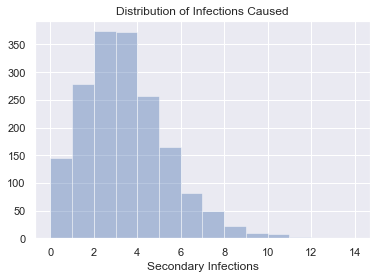

In [5]:
sns.distplot(out, bins = range(15), kde = False)
plt.title("Distribution of Infections Caused")
plt.xlabel("Secondary Infections")

## Growth Rates

We prefer to tune our model to a given growth rate, without contact tracing. The growth rate depends upon a (hazard_rate_cale, infection_reporting_prob) pair and we use the simulation script "Simulate_growth_rates.py" to perform the growth rate simulations and return a data frame of the outputs. We analyse this data frame here.

In [1]:
data = pd.read_excel("../../Data/Calibration/growth_rates.xlsx", index_col = 0)
days_simulated = 20

NameError: name 'pd' is not defined

In [43]:
data

,haz_rate_scale,infection_reporting_prob,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,0.81,0.1,200,204,227,278,391,557,757,993,...,2267,2973,3873,5071,6562,8524,10952,14063,18133,23286
1,0.81,0.2,200,204,230,282,375,524,699,930,...,1982,2549,3289,4225,5435,6916,8846,11241,14439,18394
2,0.81,0.3,200,202,222,277,376,519,719,973,...,2104,2738,3506,4475,5754,7338,9288,11779,14973,19066
3,0.81,0.4,200,201,225,283,366,518,704,928,...,2023,2583,3280,4149,5248,6704,8500,10812,13742,17401
4,0.81,0.5,200,205,232,303,408,573,752,1010,...,2044,2578,3258,4145,5171,6503,8241,10388,12993,16398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.83,0.5,200,205,233,294,417,549,710,924,...,1838,2351,2885,3568,4387,5360,6583,8006,9762,11876
446,0.83,0.6,200,205,222,276,372,486,652,860,...,1666,2079,2567,3140,3831,4721,5686,6898,8370,10172
447,0.83,0.7,200,203,217,271,347,456,579,715,...,1360,1667,2027,2423,2946,3550,4285,5196,6281,7618
448,0.83,0.8,200,203,226,275,365,471,634,791,...,1505,1849,2228,2706,3271,3972,4781,5766,7000,8420


## Estimation of Growth Rates:

We fit a linear model to the epidemics and estimate the growth rate of the epidemic.

In [53]:
infection_counts = [str(i) for i in range(days_simulated)]
number_rows = data.shape[0]

In [57]:
data_subset = data[infection_counts]

In [60]:
growth_rates = []

for _ in range(data_subset.shape[0]):
    
    # Which row are we estiamting growth rate for
    print(f"current fit; {_}", end = "\r")
    
    # Difference the counts to get the incidence, take the log to get to the growth rate
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    # temporary dataframe to pass to the linear model
    data_set_up = {
        "log_case_incidence": log_diff[10:days_simulated],
        "time": list(range(10, days_simulated))
    }
    dataframe = pd.DataFrame(data_set_up)

    # Set up the regression
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    # Unable to handle missing data, where the epidemic has died out for example
    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

In [64]:
growth_rate_data =pd.DataFrame({
    "growth_rate": growth_rates,
    "infection_reporting_prob": data["infection_reporting_prob"],
    "hazard_rate_scale": data["haz_rate_scale"]
})

In [68]:
y, X = dmatrices('growth_rate ~ hazard_rate_scale + infection_reporting_prob', 
                 data = growth_rate_data)
model_1 = sma.OLS(y, X)
res = model_1.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     4604.
Date:                Thu, 07 May 2020   Prob (F-statistic):          5.52e-299
Time:                        14:43:25   Log-Likelihood:                 1849.5
No. Observations:                 450   AIC:                            -3693.
Df Residuals:                     447   BIC:                            -3681.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [91]:
def solve_for_hazard_rate(results, infection_report_prob, growth_rate):
    """
    Sovles for the required hazard rate from the regression data.
    """
    intercept = res.params[0]
    beta_0 = res.params[1]
    beta_1 = res.params[2]
    hazard_rate_scale = (growth_rate - intercept - beta_1 * infection_report_prob) / beta_0
    return hazard_rate_scale

In [108]:
hazard_rate_getter = lambda infection_report_prob: solve_for_hazard_rate(res, infection_report_prob = infection_report_prob, growth_rate = 0.22)

In [122]:
infection_detect_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
hazard_rates = map(hazard_rate_getter, infection_detect_probs)
hazard_rate_detection_prob_pairs = dict(zip(infection_detect_probs, hazard_rates))

In [123]:
hazard_rate_detection_prob_pairs

{0.1: 0.8304838472333017,
 0.2: 0.8267109189774672,
 0.3: 0.8229379907216324,
 0.4: 0.8191650624657978,
 0.5: 0.8153921342099633,
 0.6: 0.8116192059541286,
 0.7: 0.807846277698294,
 0.8: 0.8040733494424595,
 0.9: 0.8003004211866247}

In [128]:
with open('../../Data/Calibration/hazard_rate_detection_prob_pairs.pickle', 'wb') as handle:
    pickle.dump(hazard_rate_detection_prob_pairs, handle, protocol=pickle.HIGHEST_PROTOCOL)

To load the data use the following:

In [132]:
with open('../../Data/Calibration/hazard_rate_detection_prob_pairs.pickle', 'rb') as handle:
    pairs_dict = pickle.load(handle)


## Calibrating the household secondary attack rate

The following code estimates the household secondary attack rate for a given hazard rate scale by simulating the within household epidemics. The number of simulations performed is equal to the starting_infections value.

In [4]:
model_calibrator = hct.model_calibration(haz_rate_scale = 0.795,
                                         household_haz_rate_scale = 0.795,
                                         contact_tracing_success_prob = 2/3,
                                         overdispersion = 0.36,
                                         infection_reporting_prob = 0.2,
                                         contact_trace_delay_par = 3,
                                         contact_trace = False,
                                         reduce_contacts_by = 0,
                                         starting_infections = 1000)

In [5]:
%%time
model_calibrator.estimate_secondary_attack_rate()

Wall time: 5.43 s


0.2320388349514563

In [7]:
%%time
secondary_attack_rates = []
for x in np.linspace(0.7, 0.9):
    model_calibrator = hct.model_calibration(haz_rate_scale = x,
                                            contact_tracing_success_prob = 2/3,
                                            overdispersion = 0.36,
                                            infection_reporting_prob = 0.2,
                                            contact_trace_delay_par = 3,
                                            contact_trace = False,
                                            reduce_contacts_by = 0,
                                            starting_infections = 1000)
    secondary_attack_rates.append(model_calibrator.estimate_secondary_attack_rate())
    
data = pd.DataFrame({"household_hazard_rate_scale": np.linspace(0.7, 0.9),
                     "secondary_attack_rate": secondary_attack_rates})

Wall time: 5min 37s


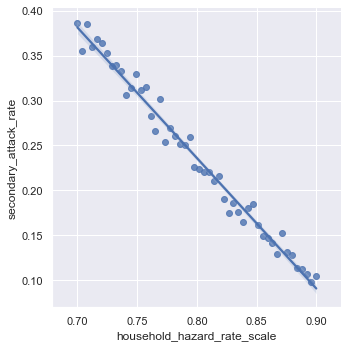

In [8]:
sns.lmplot("household_hazard_rate_scale", "secondary_attack_rate", data = data)

In [9]:
y, X = dmatrices('secondary_attack_rate ~ household_hazard_rate_scale', 
                 data = data)
model_1 = sma.OLS(y, X)
res = model_1.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     secondary_attack_rate   R-squared:                       0.983
Model:                               OLS   Adj. R-squared:                  0.983
Method:                    Least Squares   F-statistic:                     2831.
Date:                   Thu, 07 May 2020   Prob (F-statistic):           2.46e-44
Time:                           12:39:28   Log-Likelihood:                 153.94
No. Observations:                     50   AIC:                            -303.9
Df Residuals:                         48   BIC:                            -300.1
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [10]:
solve_for_x(35, res)

-23.148115578186975

A secondary household attack rate of 35% requires the hazard rate scaling to be around 0.722

### We now have the hazard rate that leads to correctly assumed within household dynamics

In practice we use the script "tune_R0.py" to estimate the $R_0$ value for a range of different inputs, however we demonstrate this below.

In [22]:
household_hazard_rate = solve_for_x(0.35, res)

In [23]:
model_calibrator = hct.model_calibration(haz_rate_scale = 0.81,
                                         household_haz_rate_scale = household_hazard_rate,
                                         contact_tracing_success_prob = 0,
                                         overdispersion = 0.36,
                                         infection_reporting_prob = 0.2,
                                         contact_trace_delay_par = 3,
                                         contact_trace = False,
                                         reduce_contacts_by = 0)

In [ ]:
model_calibration.calculate_R0()

In [80]:
x_vals = np.linspace(0.79, 0.81, 5)
repetitions = 1
hazard_rate_scale = []
R0_estimate = []
for x in x_vals:
    model_calibration = model.model_calibration(haz_rate_scale = x,
                                                household_haz_rate_scale = household_hazard_rate,
                                                contact_tracing_success_prob = 2/3,
                                                contact_trace_delay_par = 1/3,
                                                overdispersion = 0.36,
                                                infection_reporting_prob = 0.7,
                                                contact_trace = True,
                                                reduce_contacts_by = 0)
    for repeat in range(repetitions):
        print(f"x values : {x}   repeat: {repeat}", end = "\r")
        hazard_rate_scale.append(x)
        R0_estimate.append(model_calibration.calculate_R0())

In [30]:
data = pd.read_excel("../../Data/calibration_R0_vals.xlsx")

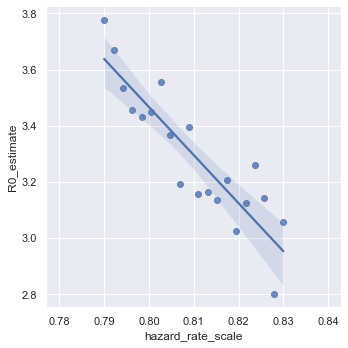

In [31]:
plot = sns.lmplot("hazard_rate_scale", "HH Secondary Attack Rate", data)

In [66]:
y, X = dmatrices('R0_estimate ~ hazard_rate_scale', 
                 data = data)
model_1 = sma.OLS(y, X)
res = model_1.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            R0_estimate   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     69.86
Date:                Sun, 03 May 2020   Prob (F-statistic):           1.31e-07
Time:                        00:35:51   Log-Likelihood:                 16.596
No. Observations:                  20   AIC:                            -29.19
Df Residuals:                      18   BIC:                            -27.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            17.1675      1.66

In [67]:
solve_for_x(3.0, res)

0.827243449006354

In [68]:
solve_for_x(2.8, res)

0.8389215257885617

In [69]:
solve_for_x(2.6, res)

0.8505996025707694